In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, find_peaks

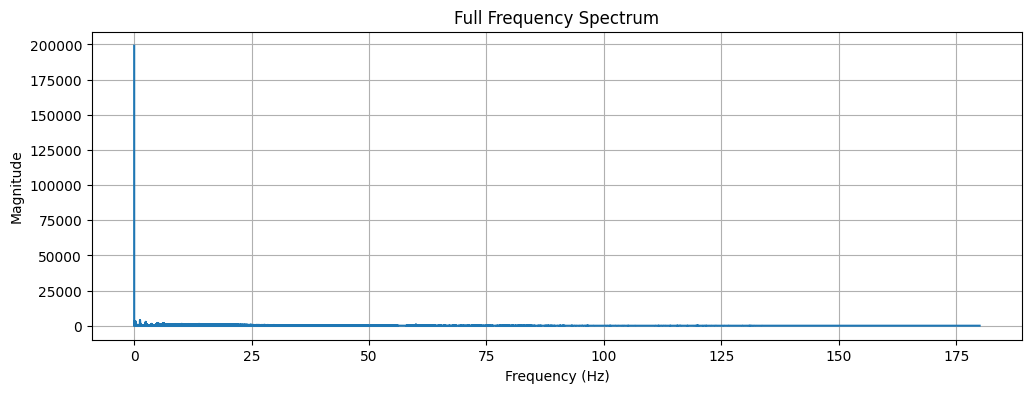

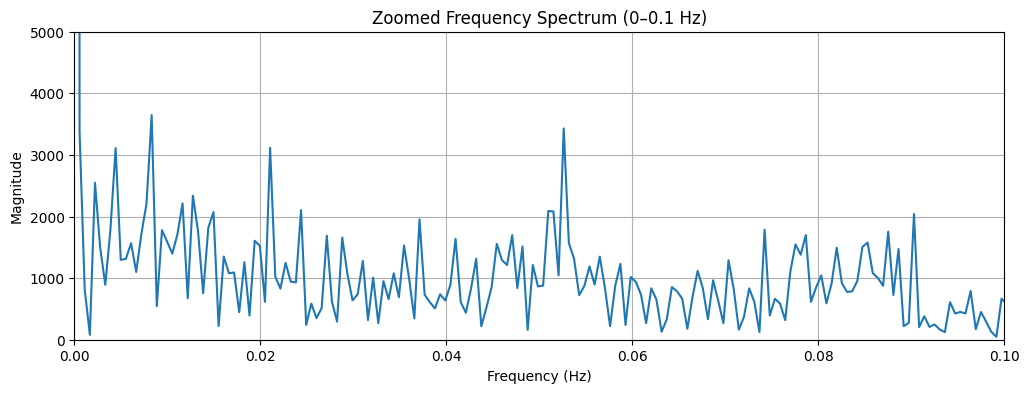

In [2]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal[:, 0]  
fs = record.fs 
n = len(signal)
yf = fft(signal)           
xf = fftfreq(n, 1/fs)
xf_pos = xf[:n//2]
yf_mag = np.abs(yf[:n//2])
plt.figure(figsize=(12, 4))
plt.plot(xf_pos, yf_mag)
plt.title("Full Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(xf_pos, yf_mag)
plt.xlim(0, 0.1)
plt.ylim(0, 5000)
plt.title("Zoomed Frequency Spectrum (0–0.1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()


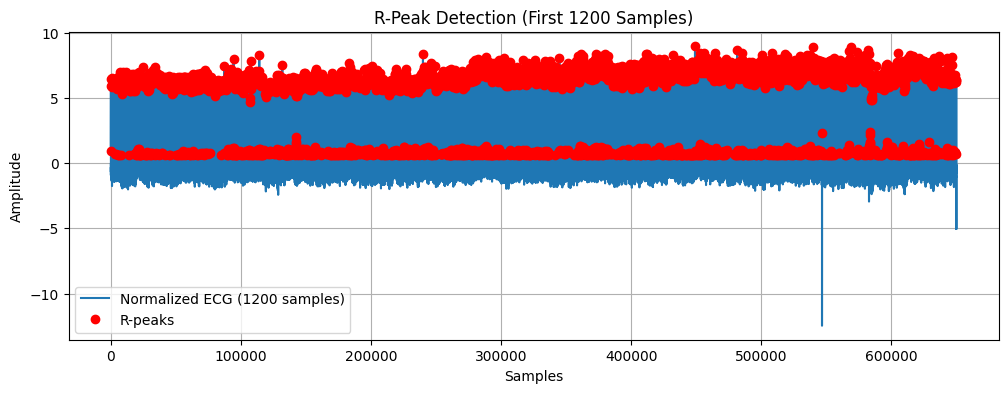

✅ R-peaks detected: 3722


In [3]:
ecg_segment = signal[:1200]
signal_normalized = (signal - np.mean(signal)) / np.std(signal)

min_peak_height = 0.6
min_peak_distance = int(0.15 * fs)

r_peaks, properties = find_peaks(
    signal_normalized,
    height=min_peak_height,
    distance=min_peak_distance
)

plt.figure(figsize=(12, 4))
plt.plot(signal_normalized, label='Normalized ECG (1200 samples)')
plt.plot(r_peaks, signal_normalized[r_peaks], 'ro', label='R-peaks')
plt.title('R-Peak Detection (First 1200 Samples)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

print(f"✅ R-peaks detected: {len(r_peaks)}")



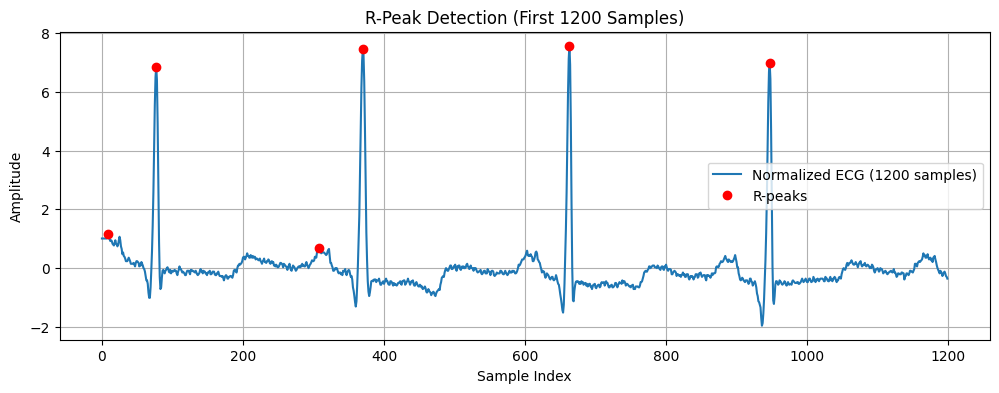

✅ R-peaks detected in first 1200 samples: 6
Peak sample indices: [  8  77 308 370 663 947]


In [4]:

ecg_segment = signal[:1200]
fs = record.fs
segment_normalized = (ecg_segment - np.mean(ecg_segment)) / np.std(ecg_segment)
min_peak_height = 0.6
min_peak_distance = int(0.10 * fs)
r_peaks, properties = find_peaks(
    segment_normalized,
    height=min_peak_height,
    distance=min_peak_distance
)
plt.figure(figsize=(12, 4))
plt.plot(segment_normalized, label='Normalized ECG (1200 samples)')
plt.plot(r_peaks, segment_normalized[r_peaks], 'ro', label='R-peaks')
plt.title("R-Peak Detection (First 1200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()
print(f"✅ R-peaks detected in first 1200 samples: {len(r_peaks)}")
print("Peak sample indices:", r_peaks)


📊 Average BPM (Raw ECG): 123.68


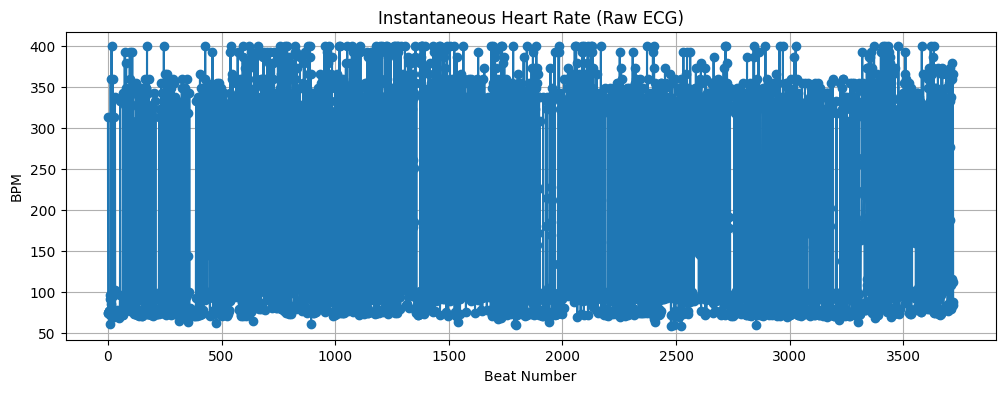

In [5]:
signal_norm = (signal - np.mean(signal)) / np.std(signal)
r_peaks_raw, _ = find_peaks(
    signal_norm,
    height=0.6,                      
    distance=int(0.15 * fs)
)
duration_sec = len(signal) / fs
bpm_raw = (len(r_peaks_raw) / duration_sec) * 60
print(f"📊 Average BPM (Raw ECG): {bpm_raw:.2f}")
rr_intervals_raw = np.diff(r_peaks_raw) / fs
instant_hr_raw = 60 / rr_intervals_raw
plt.figure(figsize=(12, 4))
plt.plot(instant_hr_raw, marker='o')
plt.title("Instantaneous Heart Rate (Raw ECG)")
plt.xlabel("Beat Number")
plt.ylabel("BPM")
plt.grid(True)
plt.show()


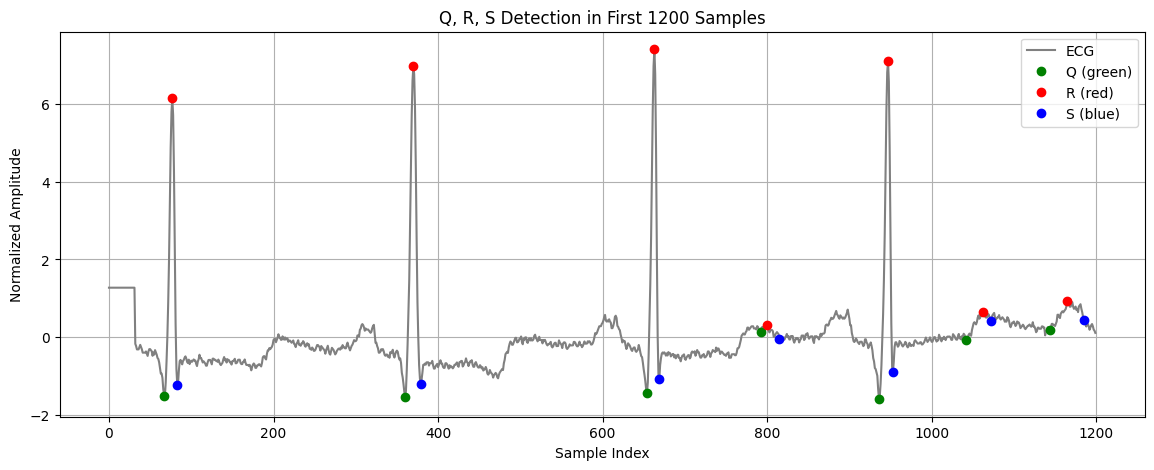

In [6]:
def lms_filter(primary_signal, reference_noise, mu=0.0001, filter_order=32):
    n_samples = len(primary_signal)
    w = np.zeros(filter_order)
    y = np.zeros(n_samples)
    e = np.zeros(n_samples)
    for n in range(filter_order, n_samples):
        x = reference_noise[n - filter_order:n][::-1]
        y[n] = np.dot(w, x)
        e[n] = primary_signal[n] - y[n]
        w += 2 * mu * e[n] * x
    return e

def lowpass_filter(signal, cutoff, fs, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='low')
    return filtfilt(b, a, signal)
reference_noise = lowpass_filter(signal, 0.7, fs)
filtered_ecg_adaptive = lms_filter(signal, reference_noise)

segment = filtered_ecg_adaptive[:1200]
segment_norm = (segment - np.mean(segment)) / np.std(segment)
r_peaks, _ = find_peaks(segment_norm, height=0.3, distance=int(0.25 * fs))
q_offset = int(0.06 * fs)
s_offset = int(0.06 * fs)

plt.figure(figsize=(14, 5))
plt.plot(segment_norm, label="Filtered ECG", color='gray')

for r in r_peaks:

    q_start = max(0, r - q_offset)
    q_end = r
    q_idx = q_start + np.argmin(segment_norm[q_start:q_end])
    s_start = r + 1
    s_end = min(len(segment_norm), r + s_offset)
    s_idx = s_start + np.argmin(segment_norm[s_start:s_end])
    plt.plot(q_idx, segment_norm[q_idx], 'go')  # Q = green dot
    plt.plot(r, segment_norm[r], 'ro')          # R = red dot
    plt.plot(s_idx, segment_norm[s_idx], 'bo')  # S = blue dot
plt.title("Q, R, S Detection in First 1200 Samples")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(["ECG", "Q (green)", "R (red)", "S (blue)"])
plt.grid(True)
plt.show()


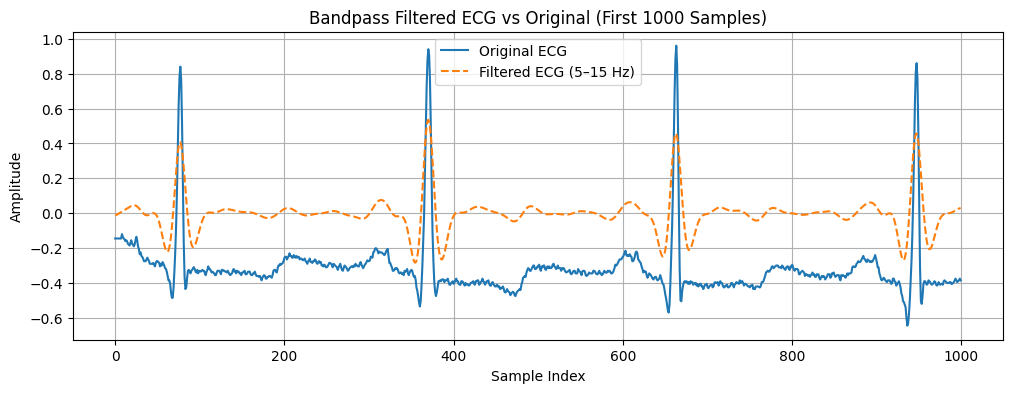

In [7]:
def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
filtered_signal = bandpass_filter(signal, 5, 15, fs)
plt.figure(figsize=(12, 4))
plt.plot(signal[:1000], label='Original ECG')
plt.plot(filtered_signal[:1000], label='Filtered ECG (5–15 Hz)', linestyle='--')
plt.title("Bandpass Filtered ECG vs Original (First 1000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


📊 Average BPM (Filtered Signal): 75.57


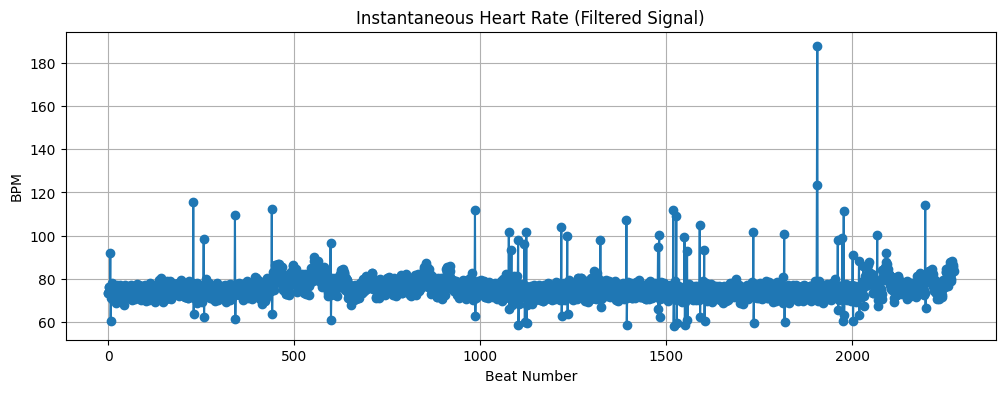

In [8]:
filtered_norm = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
r_peaks_filtered, _ = find_peaks(
    filtered_norm,
    height=0.6,
    distance=int(0.25 * fs)
)
duration_sec = len(filtered_signal) / fs
bpm_filtered = (len(r_peaks_filtered) / duration_sec) * 60
print(f"📊 Average BPM (Filtered Signal): {bpm_filtered:.2f}")
rr_intervals_filt = np.diff(r_peaks_filtered) / fs
instant_hr_filt = 60 / rr_intervals_filt
plt.figure(figsize=(12, 4))
plt.plot(instant_hr_filt, marker='o')
plt.title("Instantaneous Heart Rate (Filtered Signal)")
plt.xlabel("Beat Number")
plt.ylabel("BPM")
plt.grid(True)
plt.show()


In [9]:
def lms_filter(primary_signal, reference_noise, mu=0.01, filter_order=32):
    n_samples = len(primary_signal)
    w = np.zeros(filter_order)
    y = np.zeros(n_samples)
    e = np.zeros(n_samples)

    for n in range(filter_order, n_samples):
        x = reference_noise[n - filter_order:n][::-1]  # input vector
        y[n] = np.dot(w, x)                            # filter output
        e[n] = primary_signal[n] - y[n]                # error
        w += 2 * mu * e[n] * x                         # LMS update

    return e 


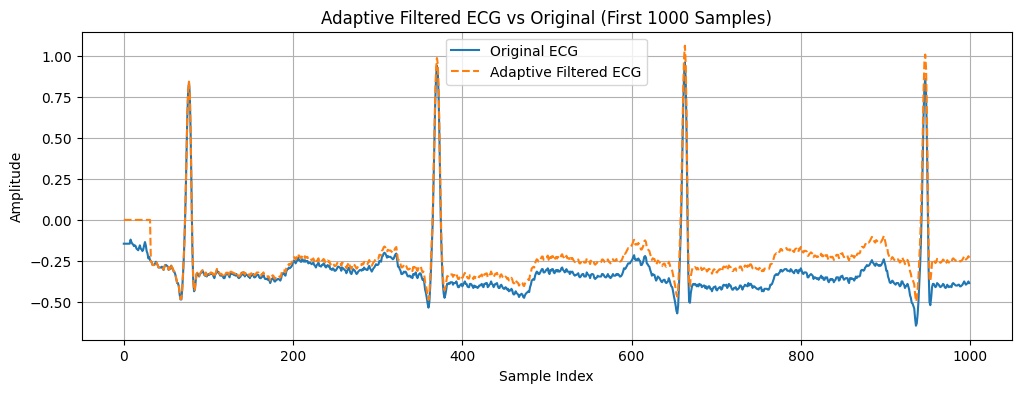

In [10]:
from scipy.signal import butter, filtfilt
def lowpass_filter(signal, cutoff, fs, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='low')
    return filtfilt(b, a, signal)

reference_noise = lowpass_filter(signal, 0.7, fs) 
primary_signal = signal
filtered_ecg_adaptive = lms_filter(primary_signal, reference_noise, mu=0.0001, filter_order=32)
plt.figure(figsize=(12, 4))
plt.plot(primary_signal[:1000], label='Original ECG')
plt.plot(filtered_ecg_adaptive[:1000], label='Adaptive Filtered ECG', linestyle='--')
plt.title("Adaptive Filtered ECG vs Original (First 1000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

